Files already downloaded and verified
Files already downloaded and verified


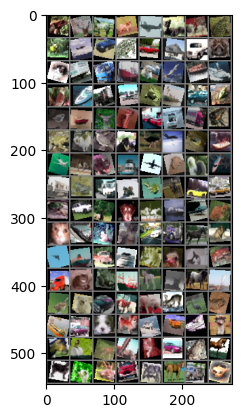

frog deer horse dog airplane deer horse frog


In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

classes = train_dataset.dataset.classes

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]}" for j in range(8)))


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
print(device)
print(net)


cuda
Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# Функція втрат
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Оптимізатор
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)  # weight_decay для L2-регуляризації

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=10
)



In [14]:
# @title Текст назви за умовчанням
import numpy as np
import torch

class EarlyStopping:
    """Зупиняє навчання, якщо валідаційна втрата не покращується."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        """
        Args:
            patience (int): Скільки епох чекати без покращень (default: 7)
            verbose (bool): Виводити повідомлення про збереження моделі (default: False)
            delta (float): Мінімальне покращення для валідаційної втрати, яке вважається значним (default: 0)
            path (str): Шлях для збереження найкращої моделі (default: 'checkpoint.pth')
            trace_func (function): Функція для логування (default: print)
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Зберігає модель, якщо валідаційна втрата покращилась."""
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [15]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(net, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=10, patience=5):
    train_losses, val_losses = [], []

    # Ініціалізація EarlyStopping
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_model.pth')

    # Підготовка динамічного графіка
    plt.ion()  # Увімкнення інтерактивного режиму
    fig, ax = plt.subplots()
    ax.set_title("Training and Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    train_line, = ax.plot([], [], label="Train Loss", color="blue")
    val_line, = ax.plot([], [], label="Validation Loss", color="orange")
    ax.legend()

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Нульова ініціалізація градієнтів
            optimizer.zero_grad()

            # Прямий прохід
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Валідація
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

        # Оновлення графіка
        train_line.set_data(range(1, len(train_losses) + 1), train_losses)
        val_line.set_data(range(1, len(val_losses) + 1), val_losses)
        ax.set_xlim(0, num_epochs + 1)
        ax.set_ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
        fig.canvas.draw()
        fig.canvas.flush_events()

        # Виклик EarlyStopping
        early_stopping(val_losses[-1], net)

        # Перевірка, чи потрібно зупинити навчання
        if early_stopping.early_stop:
            print("Early stopping")
            break

        # Крок для Scheduler
        scheduler.step()

    # Завантажити найкращу модель
    net.load_state_dict(torch.load('best_model.pth'))

    # Завершення графіка
    plt.ioff()  # Вимкнення інтерактивного режиму
    plt.show()

    return train_losses, val_losses


cuda:0


Epoch 1/20: 100%|██████████| 313/313 [00:51<00:00,  6.06it/s]


Epoch 1: Train Loss = 1.9660, Val Loss = 1.8752
Validation loss decreased (inf --> 1.875219). Saving model ...


Epoch 2/20: 100%|██████████| 313/313 [00:51<00:00,  6.11it/s]


Epoch 2: Train Loss = 1.7960, Val Loss = 1.7142
Validation loss decreased (1.875219 --> 1.714173). Saving model ...


Epoch 3/20: 100%|██████████| 313/313 [00:51<00:00,  6.11it/s]


Epoch 3: Train Loss = 1.7119, Val Loss = 1.6552
Validation loss decreased (1.714173 --> 1.655160). Saving model ...


Epoch 4/20: 100%|██████████| 313/313 [00:51<00:00,  6.10it/s]


Epoch 4: Train Loss = 1.6568, Val Loss = 1.7466
EarlyStopping counter: 1 out of 3


Epoch 5/20: 100%|██████████| 313/313 [00:51<00:00,  6.09it/s]


Epoch 5: Train Loss = 1.6163, Val Loss = 1.6075
Validation loss decreased (1.655160 --> 1.607460). Saving model ...


Epoch 6/20: 100%|██████████| 313/313 [00:51<00:00,  6.11it/s]


Epoch 6: Train Loss = 1.5807, Val Loss = 1.6808
EarlyStopping counter: 1 out of 3


Epoch 7/20: 100%|██████████| 313/313 [00:51<00:00,  6.12it/s]


Epoch 7: Train Loss = 1.5548, Val Loss = 1.4973
Validation loss decreased (1.607460 --> 1.497312). Saving model ...


Epoch 8/20: 100%|██████████| 313/313 [00:51<00:00,  6.12it/s]


Epoch 8: Train Loss = 1.5339, Val Loss = 1.5323
EarlyStopping counter: 1 out of 3


Epoch 9/20: 100%|██████████| 313/313 [00:51<00:00,  6.11it/s]


Epoch 9: Train Loss = 1.5151, Val Loss = 1.5716
EarlyStopping counter: 2 out of 3


Epoch 10/20: 100%|██████████| 313/313 [00:51<00:00,  6.09it/s]


Epoch 10: Train Loss = 1.4964, Val Loss = 1.5869
EarlyStopping counter: 3 out of 3
Early stopping


<ipython-input-15-bcbf62e160d2>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('best_model.pth'))


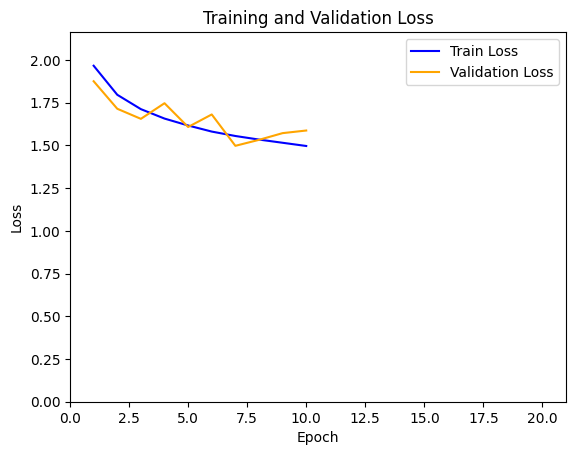

[1.9659936119573185, 1.7960233082786536, 1.7119245456811338, 1.6567732975505793, 1.6162596331617702, 1.580670795120751, 1.5548438142282894, 1.5339241835255972, 1.515149306565428, 1.496376198320724] [1.8752193013324012, 1.7141726152806342, 1.6551602927944329, 1.74657909779609, 1.6074602800079538, 1.6808169144618361, 1.4973115619224837, 1.532291613047636, 1.5715614240380782, 1.5868697045724602]


In [16]:
print(next(net.parameters()).device)
train_losses, val_losses = train_model(
    net=net,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=20,  # Максимальна кількість епох
    patience=3      # Кількість епох без покращень перед зупинкою
)
print(train_losses, val_losses)

In [17]:
# Завантаження найкращої моделі
import os
if os.path.exists("best_model.pth"):
    net.load_state_dict(torch.load("best_model.pth"))
else:
    print("Model file not found!")
    exit()

# Оцінка на тестових даних
net.eval()
test_loss = 0.0
correct = 0
total = 0
num_classes = 10
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        # Обчислення втрат
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        # Обчислення точності
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Класова точність
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

# Результати
test_loss /= total
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Точність для кожного класу
for i in range(num_classes):
    if class_total[i] > 0:
        print(f"Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%")
    else:
        print(f"Accuracy of class {i}: No samples")


<ipython-input-17-c3c814b5c717>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("best_model.pth"))


Test Loss: 1.4925, Test Accuracy: 53.83%
Accuracy of class 0: 59.50%
Accuracy of class 1: 44.30%
Accuracy of class 2: 29.30%
Accuracy of class 3: 31.90%
Accuracy of class 4: 50.60%
Accuracy of class 5: 38.80%
Accuracy of class 6: 73.80%
Accuracy of class 7: 61.70%
Accuracy of class 8: 67.20%
Accuracy of class 9: 81.20%


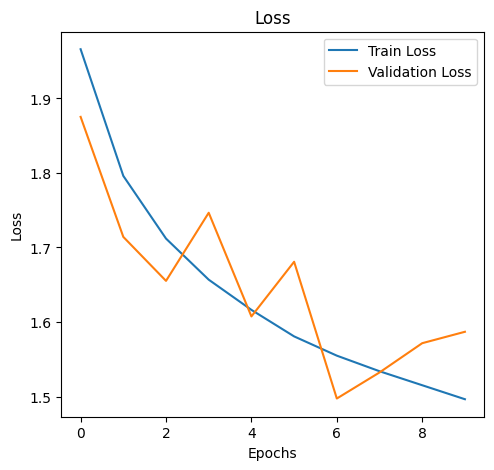

In [18]:
# Графіки втрат
plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
